# Minor Flood Frequency and Duration

```{glue:figure} fig-threshold_counts_enso
:name: fig-threshold_counts_enso
:align: left
:scale: 50%
```


In this notebook we will plot two indicators concerning flooding at the Malakal tide gauge, after first taking a general look at the type of data we are able to plot from the [UH Sea Level Center](https://uhslc.soest.hawaii.edu/stations/?stn=007#levels). These indicators are based on a 'flooding' threshold, using [relative sea level](https://tidesandcurrents.noaa.gov/sltrends/faq.html). 

<!-- Download Files: -->
<!-- [Map](../output/SL_FloodFrequency_map.png) |
[Time Series Plot](../output/SL_FloodFrequency_threshold_counts_days.png) |
[Table](../output/SL_FloodFrequency_percent_change.csv) -->



## Setup

We first need to import the necessary libraries, access the data, and make a quick plot to ensure we will be analyzing the right thing.

### Import necessary libraries.

In [1]:
# Standard libraries
import os
import datetime
from pathlib import Path
import sys

# Data manipulation libraries
import numpy as np
import pandas as pd
import xarray as xr

# Data analysis libraries
import scipy.stats as stats

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize

from urllib.request import urlretrieve #used for downloading files

# Miscellaneous
from myst_nb import glue  # used for figure numbering when exporting to LaTeX

sys.path.append("../../../functions")
from data_downloaders import download_oni_index


Next, we'll establish our directory for saving and reading data, and our output files.
```{caution}
You will need to change the variable for "output_dir" to your own output path to save figures and tables to a place of your choosing.
```

In [2]:
data_dir = Path('../../../data')
data_dir = Path(data_dir,'sea_level')

#CHANGE THIS TO YOUR PATH!!
output_dir = Path('/Users/laurac/Library/Mobile Documents/com~apple~CloudDocs/Projects/CC_indicators/CC_indicators/data/output')  # EDIT THIS TO YOUR PATH

# Create the output directory if it does not exist
output_dir.mkdir(exist_ok=True)
data_dir.mkdir(exist_ok=True)

 ##  Retrieve the Tide Station(s) Data Set(s)

Next, we'll access data from the UHSLC. The Malakala tide gauge has the UHSLC ID: 7. We will import the netcdf file into our current data directory, and take a peek at the dataset. We will also import the datums for this location. 

In [3]:
uhslc_id = 7
# download the hourly data
fname = f'h{uhslc_id:03}.nc' # h for hourly, d for daily

url = "https://uhslc.soest.hawaii.edu/data/netcdf/fast/hourly/" 

path = os.path.join(data_dir, fname)

if not os.path.exists(path):
    urlretrieve(os.path.join(url, fname), path) 

rsl = xr.open_dataset(data_dir / fname)

# remove the trailing zero from record_id. This zero is added to the record_id to make it unique if the station has multiple entries
rsl['record_id'] =(rsl['record_id']/10).astype(int)
rsl

<xarray.Dataset> Size: 6MB
Dimensions:               (record_id: 1, time: 486849)
Coordinates:
  * time                  (time) datetime64[ns] 4MB 1969-05-18T15:00:00 ... 2...
  * record_id             (record_id) int64 8B 7
Data variables:
    sea_level             (record_id, time) float32 2MB ...
    lat                   (record_id) float32 4B ...
    lon                   (record_id) float32 4B ...
    station_name          (record_id) |S7 7B ...
    station_country       (record_id) |S5 5B ...
    station_country_code  (record_id) float32 4B ...
    uhslc_id              (record_id) int16 2B ...
    gloss_id              (record_id) float32 4B ...
    ssc_id                (record_id) |S4 4B ...
    last_rq_date          (record_id) datetime64[ns] 8B ...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2025-01-27T14:35:24Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

and we'll save a few variables that will come up later for report generation.

In [4]:
station = rsl['station_name'].values[0].decode('utf-8')
country = rsl['station_country'].values[0].decode('utf-8')
startDateTime = str(rsl.time.values[0])[:10]
endDateTime = str(rsl.time.values[-1])[:10]
station_name = station + ', ' + country

# glue("station",station,display=False)
# glue("country",country, display=False)
# glue("startDateTime",startDateTime, display=False)
# glue("endDateTime",endDateTime, display=False)


### Set the Datum to MHHW

```{margin} A Note on Datums

The sea level variable in the netcdf file is sea level **relative to the station datum**. For more information on the data processing of this gauge, see the [station metdata](https://uhslc.soest.hawaii.edu/rqds/pacific/doc/qa007b.dmt). 

```

In this example, we will set the datum to MHHW. This can be hard coded, or we can write a script to read in the [station datum information](https://uhslc.soest.hawaii.edu/stations/?stn=007#datums) from UHSLC, below.

In [5]:
def get_MHHW_uhslc_datums(id, datumname): 
    
    url = 'https://uhslc.soest.hawaii.edu/stations/TIDES_DATUMS/fd/LST/fd'+f'{int(id):03}'+'/datumTable_'+f'{int(id):03}'+'_mm_GMT.csv'
    datumtable = pd.read_csv(url)
    datum = datumtable[datumtable['Name'] == datumname]['Value'].values[0]
    # ensure datum is a float
    datum = float(datum)
    return datum, datumtable

In [7]:
# extract the given datum from the dataframe
datumname = 'MHHW'

datum, datumtable = get_MHHW_uhslc_datums(uhslc_id, datumname)

rsl['datum'] = datum # already in mm
rsl['sea_level_mhhw'] = rsl['sea_level'] - rsl['datum']

# assign units to datum and sea level
rsl['datum'].attrs['units'] = 'mm'
rsl['sea_level_mhhw'].attrs['units'] = 'mm'

# glue("datum", datum, display=False)
# glue("datumname", datumname, display=False)

datumtable



,Name,Value,Description
0,Status,27-Nov-2024,Processing Date
1,Epoch,01-Jan-1983 to 31-Dec-2001,Tidal Datum Analysis Period
2,MHHW,2162,Mean Higher-High Water (mm)
3,MHW,2087,Mean High Water (mm)
4,MTL,1530,Mean Tide Level (mm)
5,MSL,1532,Mean Sea Level (mm)
6,DTL,1458,Mean Diurnal Tide Level (mm)
7,MLW,974,Mean Low Water (mm)
8,MLLW,753,Mean Lower-Low Water (mm)
9,STND,0,Station Datum (mm)


###  Assess Station Data Quality for the POR (1983-2022)

To do this, we'll plot all the sea level data to make sure our data looks correct, and then we'll truncate the data set to the time period of record (POR).

```{margin} Watch the units!
```{caution} Note that the sea_level variable here is in millimeters (mm)! If we want to plot things on a centimeter (cm) scale, we have to divide by 10.
```

Text(0, 0.5, 'Sea Level (cm, MHHW)')

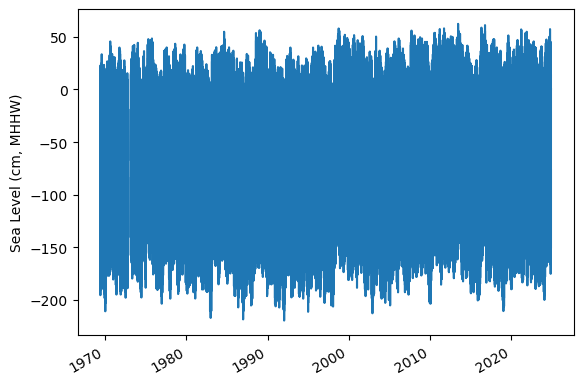

In [8]:
fig, ax = plt.subplots(sharex=True)
fig.autofmt_xdate()
ax.plot(rsl.time.values,rsl.sea_level_mhhw.T.values/10)

ax.set_ylabel(f'Sea Level (cm, {datumname})') #divide by 10 to convert to cm

# glue("TS_full_fig",fig,display=False)


#### Identify epoch for the flood frequency analysis

Now, we'll calculate trend starting from the beginning of the tidal datum analysis period epoch to the last time processed. The  epoch information is given in the datums table. 

In [9]:
#get epoch start time from the epoch in the datumtable
epoch_times = datumtable[datumtable['Name'] == 'Epoch']['Value'].values[0]

#parse epoch times into start time
epoch_start = epoch_times.split(' ')[0]
epoch_start = datetime.datetime.strptime(epoch_start, '%d-%b-%Y')

# and for now, end time the processind end time
epoch_end = epoch_times.split(' ')[2]
epoch_end = datetime.datetime.strptime(epoch_end, '%d-%b-%Y')

# last date is rsl['last_rq_date'].values
data_end = rsl['time'].values[-1]
data_end = pd.to_datetime(data_end)

# start the data at epoch_start year on May 1st
data_start = pd.Timestamp(year=epoch_start.year, month=5, day=1)
data_start = pd.to_datetime(data_start)

# end the data at April 30th of the year of the last data request
data_end = pd.Timestamp(year=data_end.year, month=4, day=30)
data_end = pd.to_datetime(data_end)

hourly_data = rsl.sel(dict(time=slice(data_start, data_end)))
hourly_data

# glue("startDataDateTime",data_start.strftime('%Y-%m-%d'), display=False)
# glue("endDataDateTime",data_end.strftime('%Y-%m-%d'), display=False)
# glue("startEpochDateTime",epoch_start.strftime('%Y-%m-%d'), display=False)
# glue("endEpochDateTime",epoch_end.strftime('%Y-%m-%d'), display=False)


<xarray.Dataset> Size: 7MB
Dimensions:               (record_id: 1, time: 359401)
Coordinates:
  * time                  (time) datetime64[ns] 3MB 1983-05-01 ... 2024-04-30
  * record_id             (record_id) int64 8B 7
Data variables:
    sea_level             (record_id, time) float32 1MB ...
    lat                   (record_id) float32 4B ...
    lon                   (record_id) float32 4B ...
    station_name          (record_id) |S7 7B b'Malakal'
    station_country       (record_id) |S5 5B b'Palau'
    station_country_code  (record_id) float32 4B ...
    uhslc_id              (record_id) int16 2B ...
    gloss_id              (record_id) float32 4B ...
    ssc_id                (record_id) |S4 4B ...
    last_rq_date          (record_id) datetime64[ns] 8B ...
    datum                 float64 8B 2.162e+03
    sea_level_mhhw        (record_id, time) float64 3MB 67.0 -39.0 ... -1.0
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2025-01-27T14:35:24Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

and plot the hourly time series

Text(0, 0.5, 'Sea Level (cm, MHHW)')

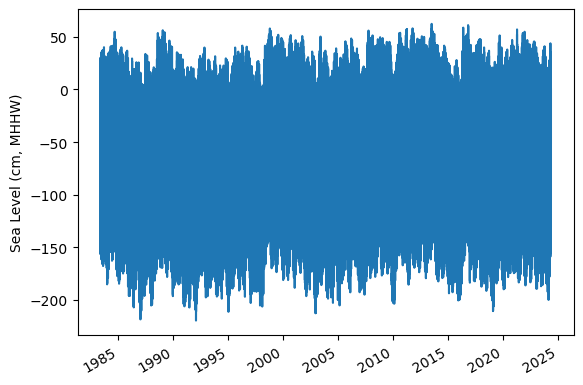

In [10]:
fig, ax = plt.subplots(sharex=True)
fig.autofmt_xdate()
ax.plot(hourly_data.time.values,hourly_data.sea_level_mhhw.T.values/10) #divide by 10 to convert to cm


ax.set_ylabel(f'Sea Level (cm, {datumname})')

# glue("TS_epoch_fig",fig,display=False)


```{glue:figure} TS_epoch_fig
:name: "fig-TS_epoch"

Full time series at {glue:text}`station`,{glue:text}`country` tide gauge for the entire record from {glue:text}`startDataDateTime` to {glue:text}`endDataDateTime`. Note that the sea level is plotted in units of cm, relative to {glue:text}`datumname`.
```

### Assign a Threshold
The threshold used here to determine a flood event is 30 cm above MHHW.
```{note}
Change the threshold and see how things change!
```

In [11]:
threshold = 30 # in cm
# glue("threshold",threshold,display=False)


## Calculate and Plot Flood Frequency
To analyze flood frequency, we will look for daily maximum sea levels for each day in our dataset, following {cite:t}`thompson_statistical_2019` and others. Then, we can group our data by year and month to visualize temporal patterns in daily SWL exceedance.   

```{glue:figure} histogram_fig
:name: "fig-histogram"
:figclass: margin

Histogram of daily maximum water levels at {glue:text}`station`,{glue:text}`country` tide gauge for the entire record from {glue:text}`startDataDateTime` to {glue:text}`endDataDateTime`, relative to {glue:text}`datumname`. The dashed red line indicates the chosen threshold of {glue:text}`threshold` cm.
```

```{margin}
Note this next code block may take a bit of time. Patience!
```

In [12]:
# Resample the hourly data to daily maximum sea level
SL_daily_max = hourly_data.resample(time='D').max()
static_vars = hourly_data[['station_name', 'station_country','station_country_code', 'datum','lat', 'lon','uhslc_id','gloss_id','ssc_id','last_rq_date']] 

SL_daily_max = SL_daily_max.assign(static_vars)
SL_daily_max

<xarray.Dataset> Size: 300kB
Dimensions:               (time: 14976, record_id: 1)
Coordinates:
  * record_id             (record_id) int64 8B 7
  * time                  (time) datetime64[ns] 120kB 1983-05-01 ... 2024-04-30
Data variables:
    sea_level             (time, record_id) float32 60kB 2.229e+03 ... 2.161e+03
    lat                   (record_id) float32 4B 7.33
    lon                   (record_id) float32 4B 134.5
    station_name          (record_id) |S7 7B b'Malakal'
    station_country       (record_id) |S5 5B b'Palau'
    station_country_code  (record_id) float32 4B 585.0
    uhslc_id              (record_id) int16 2B 7
    gloss_id              (record_id) float32 4B 120.0
    ssc_id                (record_id) |S4 4B b'mala'
    last_rq_date          (record_id) datetime64[ns] 8B 2018-12-31T22:59:59.9...
    datum                 float64 8B 2.162e+03
    sea_level_mhhw        (time, record_id) float64 120kB 67.0 -50.0 ... -1.0
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2025-01-27T14:35:24Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

Text(0.5, 1.0, 'Sea Level Daily Maximum Time Series')

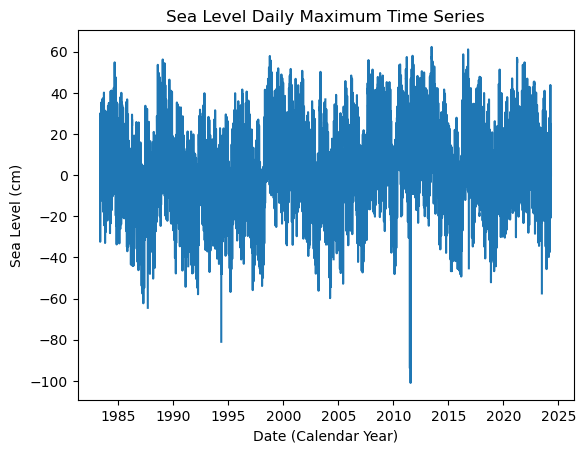

In [13]:
# make a new figure that is 15 x 5
fig, ax = plt.subplots(sharex=True)
plt.plot(SL_daily_max.time.values, SL_daily_max.sea_level_mhhw.values/10)
plt.xlabel('Date (Calendar Year)')
plt.ylabel('Sea Level (cm)')
plt.title('Sea Level Daily Maximum Time Series')

Text(22.5, 0.006210825436589414, '22.5 cm')

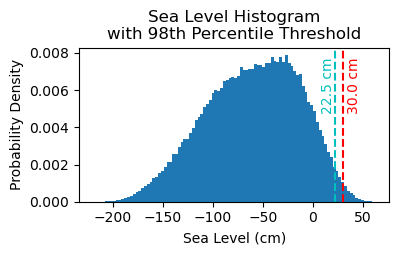

In [14]:
# Make a pdf of the data with 95th percentile threshold

sea_level_data_cm = hourly_data['sea_level_mhhw'].values/10 # convert to cm
#remove nans
sea_level_data_cm = sea_level_data_cm[~np.isnan(sea_level_data_cm)]

fig, ax = plt.subplots(figsize=(4,2))
ax.hist(sea_level_data_cm, bins=100, density=True, label='Sea Level Data')

#get 95th percentile
threshold98 = np.percentile(sea_level_data_cm, 98)

ax.axvline(threshold, color='r', linestyle='--', label='Threshold: {:.4f} cm'.format(threshold))
ax.axvline(threshold98, color='c', linestyle='--', label='Threshold: {:.4f} cm'.format(threshold98))

ax.set_xlabel('Sea Level (cm)')
ax.set_ylabel('Probability Density')
# make the title two lines
ax.set_title('Sea Level Histogram\nwith 98th Percentile Threshold')

# add label to dashed line
# get value of middle of y-axis for label placement
ymin, ymax = ax.get_ylim()
yrange = ymax - ymin
y_middle = ymin + 0.75*yrange

ax.text(threshold+4, y_middle, '{:.1f} cm'.format(threshold), rotation=90, va='center', ha='left', color='r')
ax.text(threshold98, y_middle, '{:.1f} cm'.format(threshold98), rotation=90, va='center', ha='right', color='c')

# glue("histogram_fig", fig, display=False)

In [15]:
# Find all days where sea level exceeds the threshold
flood_days_df = SL_daily_max.to_dataframe().reset_index()

flood_days_df['year_storm'] = flood_days_df['time'].dt.year
flood_days_df.loc[flood_days_df['time'].dt.month > 4, 'year_storm'] = flood_days_df['time'].dt.year + 1

#filter flood hours
flood_days_df = flood_days_df[flood_days_df['sea_level_mhhw'] > threshold*10]

flood_days_per_year = flood_days_df.groupby('year_storm').size().reset_index(name='flood_days_count')

all_years = pd.DataFrame({'year_storm': range(flood_days_df['year_storm'].min(), flood_days_df['year_storm'].max() + 1)})

flood_days_per_year = all_years.merge(flood_days_per_year, on='year_storm', how='left').fillna(0)

flood_days_per_year['flood_days_count'] = flood_days_per_year['flood_days_count'].astype(int)


In [16]:
flood_hours_df = hourly_data.to_dataframe().reset_index()

flood_hours_df['year_storm'] = flood_hours_df['time'].dt.year
flood_hours_df.loc[flood_hours_df['time'].dt.month > 4, 'year_storm'] = flood_hours_df['time'].dt.year + 1

#filter flood hours
flood_hours_df = flood_hours_df[flood_hours_df['sea_level_mhhw'] > threshold*10]

flood_hours_per_year = flood_hours_df.groupby('year_storm').size().reset_index(name='flood_hours_count')

all_years = pd.DataFrame({'year_storm': range(flood_hours_df['year_storm'].min(), flood_hours_df['year_storm'].max() + 1)})

flood_hours_per_year = all_years.merge(flood_hours_per_year, on='year_storm', how='left').fillna(0)

flood_hours_per_year['flood_hours_count'] = flood_hours_per_year['flood_hours_count'].astype(int)

Let's have a quick look at the data in flood_hours_per_year:

In [17]:
# show the first few rows of the flood_days_per_year dataframe
flood_days_per_year.head()

,year_storm,flood_days_count
0,1984,32
1,1985,38
2,1986,9
3,1987,0
4,1988,2


In [18]:
# add nino
p_data = 'https://psl.noaa.gov/data/correlation/oni.data'
oni = download_oni_index(p_data)

/Users/laurac/Library/Mobile Documents/com~apple~CloudDocs/Projects/CC_indicators/CC_indicators/notebooks_historical/ocean/1_sea_level/../../../functions/data_downloaders.py:242: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  oni = pd.read_csv(


In [19]:
# add column for oni values to flood_days_per_year, with average ONI value for the storm year
# first establish storm year for each , given that the date is the index
oni['year_storm'] = oni.index.year

# if the month is less than 5, then the storm year is the year before
oni.loc[oni.index.month > 4, 'year_storm'] = oni.loc[oni.index.month > 4, 'year_storm'] + 1

# group by storm year and get the mean ONI value
oni_year = oni.groupby('year_storm').mean()

# merge the oni values with the flood_days_per_year dataframe
flood_days_per_year = flood_days_per_year.merge(oni_year, on='year_storm', how='left')


### Plot Flood Frequency Counts 

The flood frequency counts are defined as the number of time periods that exceed a given threshold within a year. This plot follows {cite:t}`center_for_operational_oceanographic_products_and_services_us_sea_2014`.

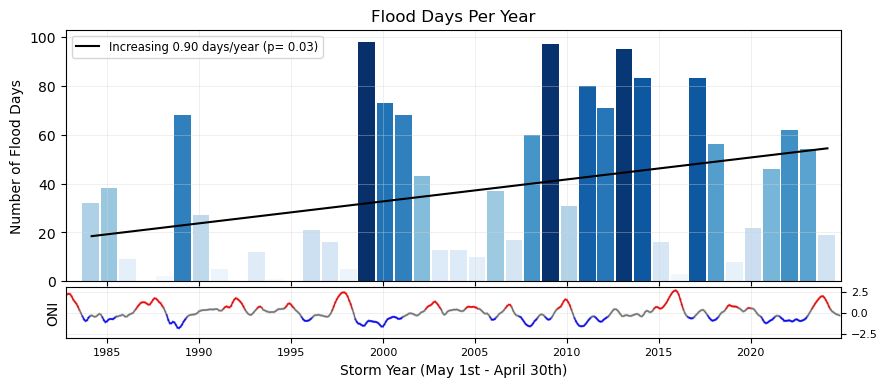

In [20]:
# Create two subplots sharing the same x-axis
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 4),  sharex=True, gridspec_kw={"height_ratios": [5, 1],"hspace": 0.04, }
)
# Plot the bar chart for flood days on the first subplot
x_values = flood_days_per_year['year_storm']  # Assuming this is already aligned to storm years
x_values_offset = x_values - 4/12  # Shift x-values to align with the storm years
y_values = flood_days_per_year['flood_days_count']
bar_width = 0.9

flooding_colors = sns.color_palette("Blues", as_cmap=True)
norm = Normalize(vmin=min(y_values), vmax=max(y_values))
colors = flooding_colors(norm(y_values))

ax1.bar(x_values_offset, y_values, width=bar_width, color=colors, align='edge')

ax1.set_ylabel('Number of Flood Days')
ax1.set_title('Flood Days Per Year')
ax1.grid(color='lightgray', linestyle='-', linewidth=0.5, alpha=0.5)

# Plot the ONI index on the second subplot
oni['year_float'] = oni.index.year + (oni.index.month - 1) / 12

# shifted x-axis to align with flood days histogram storm years

# x_offset = flood_days_per_year['year_storm'].min() + 4/12

ax2.plot(oni['year_float'], oni['ONI'], color='k',linewidth=0.5, label='ONI')
ax2.set_ylabel('ONI')
ax2.set_xlabel('Storm Year (May 1st - April 30th)')
ax2.grid(color='lightgray', linestyle='-', linewidth=0.5, alpha=0.5)
ax2.set_ylim(-3, 3)

ax1.set_xlim(x_values_offset.min()-bar_width, x_values.max()+bar_width)
ax2.set_xlim(x_values_offset.min()-bar_width, x_values.max()+bar_width)

# Define thresholds for ONI values
el_nino_threshold = 0.5
la_nina_threshold = -0.5

# Loop through the data to plot segments with different colors
for i in range(len(oni) - 1):
    x = oni['year_float'].iloc[i:i+2]
    y = oni['ONI'].iloc[i:i+2]
    
    if y.mean() >= el_nino_threshold:
        color = 'red'
    elif y.mean() <= la_nina_threshold:
        color = 'blue'
    else:
        color = 'gray'
    
    ax2.plot(x, y, color=color, linewidth=1.5, alpha=0.5)




# put y-axis labels on the right side for ax2
ax2.yaxis.tick_right()

# set font size for tick labels
ax2.tick_params(axis='both', which='major', labelsize=8)

# Add the trendline to the first subplot

# Aggregating data and fitting the trendline

slope, intercept, r_value, p_value, std_err = stats.linregress(x_values_offset+0.5, y_values)
trendDays = intercept + slope * (x_values_offset+0.5)
trendLabel = 'Increasing {:.2f} days/year (p= {:.2f})'.format(slope,p_value)

if p_value < 0.05:
    linestyleTrend = '-'
else:
    linestyleTrend = '--'

ax1.plot(x_values_offset+0.5, trendDays, color='black', linestyle=linestyleTrend, label=trendLabel)

# Adding the legend
ax1.legend(loc='upper left', fontsize='small')

# # save the trendline values
# glue("day_per_year_trend",slope,display=False)
# glue("p_value_days",p_value,display=False)

# # save the figure
# glue("fig-threshold_counts_enso", fig, display=False)

# save to output directory
fig.savefig(output_dir / "SL_FloodFrequency_threshold_counts_days.png", dpi=300, bbox_inches='tight')



```{glue:figure} threshold_counts_days_fig_enso
:name: "fig-threshold_counts_enso"

Flood frequency counts above a threshold of {glue:text}`threshold:.0f` cm per year at {glue:text}`station`,{glue:text}`country` tide gauge from {glue:text}`startDataDateTime` to {glue:text}`endDataDateTime`. The bottom subplot shows the ONI index for the same time period, with red corresponding to El Nino conditions (ONI>0.5) and blue corresponding to La Nina conditions (ONI<-0.5). A trendline is added to the plot, showing a significant (p = {glue:text}`p_value_days:.2f`) increase in flood days per year ({glue:text}`days_per_year_trend:.2f` days/year).
```

Here is a more simplified plot of the same thing.

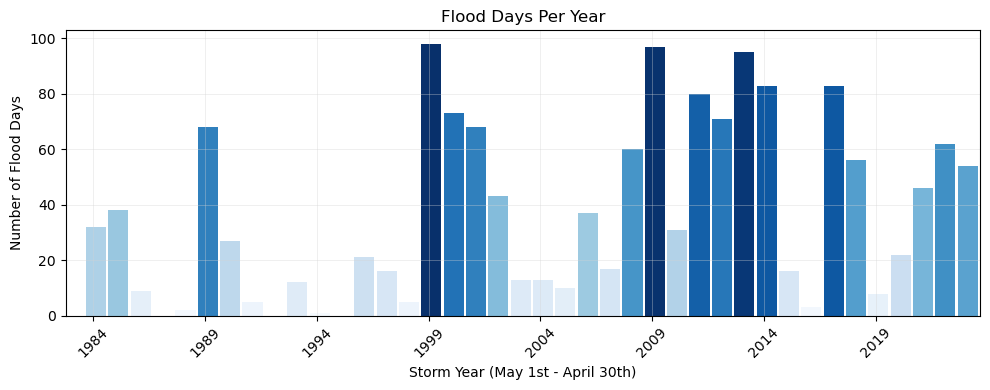

In [21]:
x_values = flood_days_per_year['year_storm']  # Assuming this is already aligned to storm years
y_values = flood_days_per_year['flood_days_count']
bar_width = 0.9  # Adjust the width of the bars

# Offset x-values by 4/12 (4 months = May start)
x_values_offset = x_values - 4/12

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(x_values_offset, y_values, width=bar_width, color=colors, align='edge')

# Add gridlines for better readability
ax.grid(color='lightgray', linestyle='-', linewidth=0.5, alpha=0.5)

# Add labels and title
ax.set_xlabel('Storm Year (May 1st - April 30th)')
ax.set_ylabel('Number of Flood Days')
ax.set_title('Flood Days Per Year')

# Adjust x-ticks to match storm years
ax.set_xticks(x_values[::5])  # Use storm years for ticks, spaced every 5 years
ax.set_xticklabels(x_values[::5].astype(int), rotation=45)

# Set x-limits to ensure all bars are visible
ax.set_xlim(x_values_offset.min() - bar_width, x_values_offset.max())

# Show the plot
plt.tight_layout()
plt.show()

```{glue:figure} threshold_counts_days_fig
:name: "fig-threshold_counts"

Flood frequency counts above a threshold of {glue:text}`threshold:.3f` cm per year at {glue:text}`station`,{glue:text}`country` tide gauge from {glue:text}`startDataDateTime` to {glue:text}`endDataDateTime`. 
```

### Plot Flood Duration

This next plot examines the average duration of flooding events as defined by the threshold. 
Note that in this calculation these hours need not be continuous (and thus any changes in the scale of the flooding in terms of time-extent is not readily apparent, only the yearly summation.)

```{margin}
This colorbar uses a heatmap coloring (darker colors = more hours per year). It is normalized by the minimum and maximum of the yearly flood hours data.
```

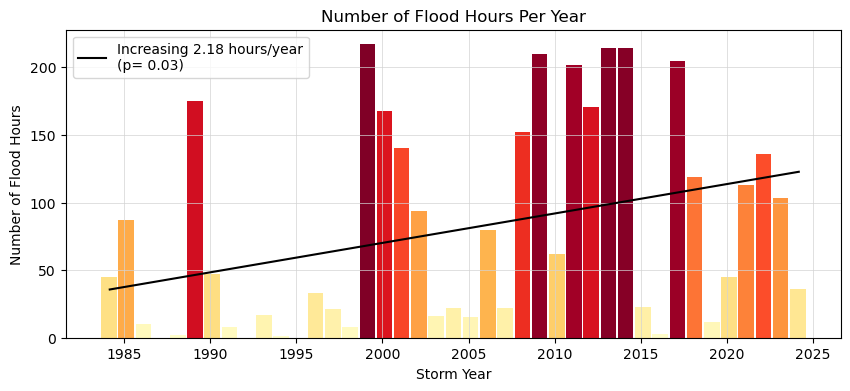

In [22]:

# Adjusting the heatmap palette to improve readability
from matplotlib.colors import Normalize

adjusted_heatmap_palette = sns.color_palette("YlOrRd", as_cmap=True)



# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 4))
# Adding a light gray grid
ax.grid(color='lightgray', linestyle='-', linewidth=0.5)

y_values = flood_hours_per_year['flood_hours_count']
x_values = flood_hours_per_year['year_storm']
bar_width = 0.9
norm = Normalize(vmin=min(y_values), vmax=max(y_values))
colors = adjusted_heatmap_palette(norm(y_values))

# Offset x-values by 4/12 (4 months = May start)
x_values_offset = x_values - 4/12

ax.bar(x_values_offset, y_values, width=bar_width, color=colors, align='edge')

ax.set_xlabel('Storm Year')
ax.set_ylabel('Number of Flood Hours')
ax.set_title('Number of Flood Hours Per Year')

slope, intercept, r_value, p_value, std_err = stats.linregress(x_values_offset+0.5, y_values)
trendHours = intercept + slope * (x_values_offset+0.5)
trendLabel = 'Increasing {:.2f} hours/year\n(p= {:.2f})'.format(slope, p_value)

if p_value < 0.05:
    linestyleTrend = '-'
else:
    linestyleTrend = '--'

ax.plot(x_values_offset+0.5, trendHours, color='black', linestyle=linestyleTrend, label=trendLabel)

# Adding the legend
ax.legend(loc='upper left', fontsize='small')

# # save the trendline values
# glue("hours_per_year_trend",slope,display=False)
# glue("p_value_hours",p_value,display=False)

# Adding the legend
ax.legend(loc='upper left')

# glue("duration_fig", fig, display=False)

# save the figure
fig.savefig(output_dir / 'SL_FloodFrequency_threshold_counts_hours.png', bbox_inches='tight')

```{glue:figure} duration_fig
:name: "fig-duration"

Average flood duration in hours above a threshold of {glue:text}`threshold:.0f` cm per year at {glue:text}`station`,{glue:text}`country` tide gauge from {glue:text}`startDataDateTime` to {glue:text}`endDataDateTime`. A trendline is added to the plot, showing a significant (p = {glue:text}`p_value_hours:.2f`) increase in flood days per year ({glue:text}`hours_per_year_trend:.2f` hours/year).
```

## Calculate the percent change over time

Next we'll calculate the percent change over the POR at the tide station/s, for both Frequency and Duration.

The next code cell fits a trend line to the flood days per year data and calculates the trend line.
It then plots the data and the trend line in a figure, and calculates the percent change in flood days per year using the trend line. The same process is repeated for flood hours per year.


Now we'll generate a table with this information, which will be saved as a .csv in the output directory specified at the top of this notebook.

In [23]:
# Calculate the total number of days/hours exceeding the threshold
total_flood_days = flood_days_per_year['flood_days_count'].sum()
total_flood_hours = flood_hours_per_year['flood_hours_count'].sum()

# Calculate the average number of flood days and hours per year
average_flood_days_per_year = total_flood_days / len(flood_days_per_year)
average_flood_hours_per_year = flood_hours_per_year['flood_hours_count'].mean()

# Find the maximum number of flood days in a single year
max_flood_days = flood_days_per_year['flood_days_count'].max()
max_flood_days_year = flood_days_per_year.loc[flood_days_per_year['flood_days_count'].idxmax(), 'year_storm']

# Find the maximum number of flood hours in a single year
max_flood_hours = flood_hours_per_year['flood_hours_count'].max()
max_flood_hours_year = flood_hours_per_year.loc[flood_hours_per_year['flood_hours_count'].idxmax(), 'year_storm']

# calculate the absolute percent change over the entire period using the first and last part of the trend
percent_change_days = (trendDays.iloc[-1]-trendDays.iloc[0])/trendDays.iloc[0]*100
percent_change_hours = (trendHours.iloc[-1]-trendHours.iloc[0])/trendHours.iloc[0]*100

In [24]:
# Create a dataframe for statistics
summary_stats = [
    ('Total Flood Days', int(total_flood_days)),
    ('Average Flood Days per Year', int(average_flood_days_per_year)),
    ('Max Flood Days in a Single Year', int(max_flood_days)),
    ('Year of Max Flood Days', int(max_flood_days_year)),
    ('Total Flood Hours', int(total_flood_hours)),
    ('Average Flood Hours per Year', int(average_flood_hours_per_year)),
    ('Max Flood Hours in a Single Year', int(max_flood_hours)),
    ('Year of Max Flood Hours', int(max_flood_hours_year)),
    ('Percent Change in Flood Days', int(percent_change_days)),
    ('Percent Change in Flood Hours', int(percent_change_hours))
]

# Convert the list of tuples to a pandas DataFrame
summary_stats_df = pd.DataFrame(summary_stats, columns=['Statistic', 'Value'])

# Display the DataFrame
summary_stats_df

,Statistic,Value
0,Total Flood Days,1494
1,Average Flood Days per Year,36
2,Max Flood Days in a Single Year,98
3,Year of Max Flood Days,1999
4,Total Flood Hours,3248
5,Average Flood Hours per Year,79
6,Max Flood Hours in a Single Year,217
7,Year of Max Flood Hours,1999
8,Percent Change in Flood Days,194
9,Percent Change in Flood Hours,244


## Create a sub-annual table
Here we'll turn our 'flooding days' into a dataframe to look at monthly changes through time.

In [25]:
import calendar
# Make a dataframe with years as rows and months as columns
df = SL_daily_max.to_dataframe().reset_index()
df['flood_day'] = df['sea_level_mhhw'] > threshold*10

# keep only the flood day and time columns
df = df[['time', 'flood_day']]

df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df = df.drop(columns='time')

# sum the number of flood days in each month for each year
df = df.groupby(['year', 'month']).sum()

# pivot the table
df = df.pivot_table(index='year', columns='month', values='flood_day')

# rename months to month names
df.columns = calendar.month_abbr[1:]

# add a column for the total number of flood days in each year
df['Annual'] = df.sum(axis=1)



# add a row for the total number of flood days in each month, normalized the total flood days (last row, last column)
df.loc['Monthly Total (%)'] = df.sum()
df.loc['Monthly Total (%)'] = 100*df.loc['Monthly Total (%)']/df.loc['Monthly Total (%)', 'Annual']

station_name = SL_daily_max['station_name'].values[0].decode('utf-8') +', ' + SL_daily_max['station_country'].values[0].decode('utf-8')

tableTitle = station_name + ': Days Exceeding ' + str(threshold) + ' cm above MHHW'
# Apply background gradient and add a title with larger text
styled_df = df.style.background_gradient(
    cmap='Blues', axis=None, subset=(df.index[:-1], df.columns[:-1])
).format("{:.0f}").background_gradient(
    cmap='Purples', axis=None, subset=(df.index[-1], df.columns[:-1])
).format("{:.0f}").set_caption(tableTitle).set_table_styles([
    {
        'selector': 'caption',
        'props': [('font-size', '16px'), ('margin-bottom', '10px')]
    }
])

styled_df


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
year,,,,,,,,,,,,,
1983,nan,nan,nan,nan,1,5,5,4,3,2,1,0,21
1984,2,3,1,5,5,0,4,9,6,3,4,0,42
1985,0,0,3,4,3,2,0,0,2,2,0,0,16
1986,0,0,0,0,0,0,0,0,0,0,0,0,0
1987,0,0,0,0,0,1,0,1,0,0,0,0,2
1988,0,0,0,0,0,0,4,8,6,7,4,3,32
1989,17,7,7,5,4,0,2,6,5,4,4,0,61
1990,0,0,0,2,3,1,0,0,1,0,0,0,7
1991,0,0,0,0,0,0,0,0,0,0,0,0,0


We can also make a nice plot for printed reports.

In [26]:
#make a pretty pdf of the table with great_tables
from great_tables import GT,html

dfGT = df.copy()
dfGT['year'] = df.index

# put the year column first
cols = dfGT.columns.tolist()
cols = cols[-1:] + cols[:-1]
dfGT = dfGT[cols]
dfGT.reset_index(drop=True, inplace=True)



# Create a GreatTable object
table = (GT(dfGT)
.fmt_number(columns=calendar.month_abbr[1:13], decimals=0)
.fmt_number(columns=['Annual'], decimals=0)
.tab_header(title = 'Days Exceeding 30 cm above MHHW', subtitle = station_name)
.data_color(domain = [0,20],
            columns=calendar.month_abbr[1:13],
            rows = list(range(len(dfGT)-1)),
            palette=["white", "lightblue"])
.data_color(domain = [0,20],
            columns=calendar.month_abbr[1:13],
            rows = [-1],
            palette=["white", "purple"])
.opt_table_outline(style='solid', width='3px', color='white')
)

# save table as png
tableName = station_name + '_flood_days_intra_annual.png'
savePath = os.path.join(output_dir, tableName)

# replace any commas or spaces with underscores
# savePath = savePath.replace(' ', '_')
table.save(savePath)

# Load Image
from IPython.display import Image
imgTable = Image(filename=savePath)

# Glue the image with a name
# glue("imgTable", imgTable, display=False)


```{glue:figure} imgTable
:name: "imgTable"
:scale: 40%
Monthly and Annual tally of flooding days at {glue:text}`station`, {glue:text}`country` .
```

## Create a map
In this next section we'll create a map with an icon depicting the percent change over the Period of Record at the tide station/s, for both Frequency and Duration.


The following cell defines a function to add arrow icons denoting percent change.

In [27]:
# make a function for adding the arrows
def add_arrow(ax, lat,lon,percent_change,crs, vmin, vmax):
# make colormap of percent change
    adjusted_heatmap_palette = sns.color_palette("YlOrRd", as_cmap=True)

    # Prepare data for quiver plot
    U = np.zeros_like(lon)  # Dummy U component (no horizontal movement)
    V = percent_change/100   # V component scaled by percent change
    arrow_scale = 5  # Adjust as necessary for arrow size
    arrow_width = 0.01  # Adjust for desired arrow thickness

    # Quiver plot
    q = ax.quiver(lon,lat, U, V, transform=crs, scale=arrow_scale,
              color=adjusted_heatmap_palette(percent_change / vmax), 
              cmap=adjusted_heatmap_palette, clim=(vmin, vmax), width=arrow_width)

And here is our final plotting code:

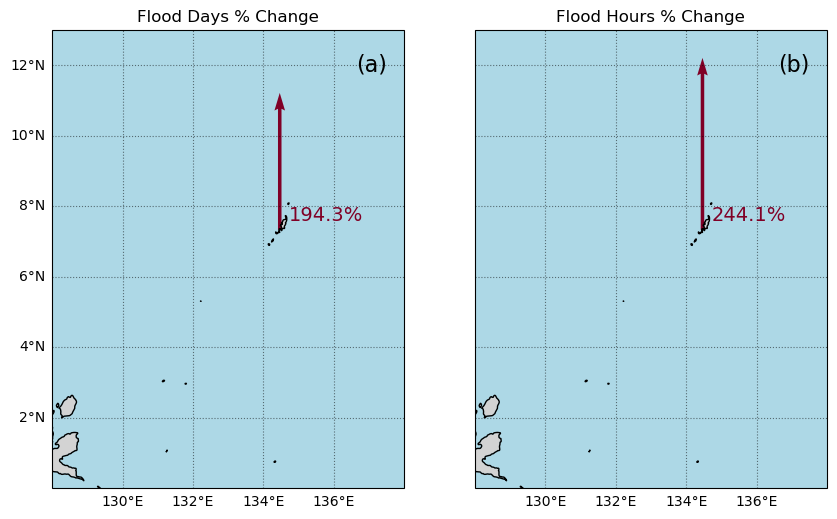

In [28]:
xlims = [128, 138]
ylims = [0, 13]
vmin, vmax = 0,100

# fig, ax, crs,cmap = plot_map(vmin,vmax,xlims,ylims)
crs = ccrs.PlateCarree()
fig, axs = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={'projection': crs})


for i, ax in enumerate(axs):
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    ax.coastlines()

    # Fill in water
    ax.add_feature(cfeature.LAND, color='lightgrey')
    # add a) b) labels
    ax.text(0.95, 0.95, f'({chr(97 + i)})', 
            horizontalalignment='right', verticalalignment='top', transform=ax.transAxes,
            fontsize=16)
    
    ax.add_feature(cfeature.OCEAN, color='lightblue')

    # add map grid
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                  alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks())
    
    #remove labels from top and right axes
    gl.top_labels = False
    gl.right_labels = False

    if ax == axs[1]:
        gl.left_labels = False

add_arrow(axs[0], rsl['lat'], rsl['lon'], percent_change_days, crs, vmin, vmax)
add_arrow(axs[1], rsl['lat'], rsl['lon'], percent_change_hours, crs, vmin, vmax)

# Put titles on the subplots
axs[0].set_title('Flood Days % Change')
axs[1].set_title('Flood Hours % Change')

# Add text for percent change
for i in range(len(rsl['lon'])):
    axs[0].text(rsl['lon'][i] + 0.25, rsl['lat'][i] + 0.25, '{:.1f}%'.format(percent_change_days), fontsize=14,
                color=adjusted_heatmap_palette(percent_change_days / vmax))
    axs[1].text(rsl['lon'][i] + 0.25, rsl['lat'][i] + 0.25, '{:.1f}%'.format(percent_change_hours), fontsize=14,
                color=adjusted_heatmap_palette(percent_change_hours / vmax))


# glue("mag_fig", fig, display=False)

# Save the figure
output_file_path = output_dir / 'SL_FloodFrequency_map.png'
fig.savefig(output_file_path, dpi=300, bbox_inches='tight')


```{glue:figure} mag_fig
:name: "mag_fig"

Map of the percent change in average flood (a) days and (b) hours per year above a threshold of {glue:text}`threshold:.1f` cm above {glue:text}`datumname` per year at {glue:text}`station`,{glue:text}`country` tide gauge from {glue:text}`startDataDateTime` to {glue:text}`endDataDateTime`
```

## Citations

```{bibliography}
:style: alpha
:filter: docname in docnames
```